# 2. Object recognition

Detect objects in images by predicting bounding boxes around them and evaluate the performance of object recognition models.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

import torch
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
import torch.nn as nn
import torchvision

from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.detection import FasterRCNN

## Bounding boxes

### Image tensors

A coffee company has an object detection project where they need to annotate objects of interest, in this case, espresso shots. You have created a list with the bounding box coordinates for an espresso shot image. Now, you need to convert the image and the coordinates into tensors.

In [2]:
image = Image.open("images/Espresso.jpeg")
bbox = [10, 10, 200, 200]

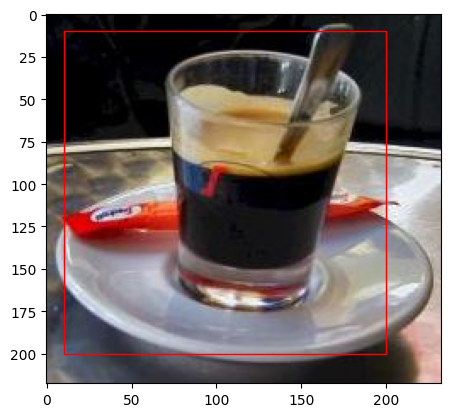

In [3]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a rectangle patch
rect = patches.Rectangle(
    (10, 10), 190, 190, linewidth=1, edgecolor="r", facecolor="none"
)

# Add the patch to the axes
ax.add_patch(rect)

plt.show()

Instructions:

- Convert the `bbox` into tensors using `torch.tensor()`.
- Reshape `bbox_tensor` by adding a batch dimension using `unsqueeze(0)`.
- Create a transform to resize `image` to `(224)` and transform to an unscaled image tensor.
- Apply `transform` to `image`.

In [4]:
# Convert bbox into tensors
bbox_tensor = torch.tensor(bbox)
print(bbox_tensor)

# Add a new batch dimension
bbox_tensor = bbox_tensor.unsqueeze(0)
print(bbox_tensor)

# Resize the image and transform to tensor
#transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize(224), transforms.PILToTensor()])

# Apply transform to image
image_tensor = transform(image)
print(image_tensor)

tensor([ 10,  10, 200, 200])
tensor([[ 10,  10, 200, 200]])
tensor([[[  0,   0,   1,  ...,  25,  24,  23],
         [  0,   0,   1,  ...,  26,  25,  23],
         [  0,   0,   0,  ...,  27,  26,  23],
         ...,
         [130, 133, 134,  ..., 233, 234, 231],
         [135, 135, 135,  ..., 226, 227, 230],
         [135, 137, 135,  ..., 226, 227, 230]],

        [[  1,   1,   2,  ...,  30,  29,  28],
         [  1,   1,   2,  ...,  31,  30,  28],
         [  1,   1,   1,  ...,  32,  31,  28],
         ...,
         [119, 122, 123,  ..., 185, 186, 182],
         [121, 124, 124,  ..., 178, 179, 181],
         [121, 123, 124,  ..., 178, 179, 181]],

        [[  5,   5,   6,  ...,  33,  32,  31],
         [  5,   5,   6,  ...,  34,  33,  31],
         [  5,   5,   5,  ...,  35,  34,  31],
         ...,
         [117, 120, 121,  ..., 180, 181, 177],
         [118, 120, 120,  ..., 174, 175, 177],
         [118, 120, 118,  ..., 174, 175, 177]]], dtype=torch.uint8)


Usually, we use transforms.ToTensor() float transformation for images to scale them in the range [0,1]. However, the bounding box requires an unscaled image type with the range [0, 255], so we use transforms.PILToTensor()

### Drawing a bounding box

Having prepared the image and bounding box tensors, you can now draw the box on top of the image and visually inspect its accuracy.

The coordinates have been assigned to the variables: x_min, y_min, x_max, y_max.

In [5]:
x_min = 70
x_max = 190
y_min = 17
y_max = 180

Intructions:

- Define the bounding box `bbox` as list consisting of `x_min`, `y_min`, `x_max`, and `y_max`.
- Pass `image_tensor` and `bbox_tensor` to `draw_bounding_boxes` to draw the box on top of the image and assign the output to `img_bbox`.
- Convert the `img_bbox` tensor to image.

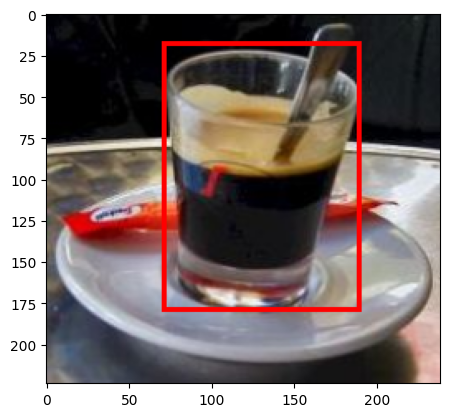

In [6]:
# Define the bounding box coordinates
bbox = [x_min, y_min, x_max, y_max]
bbox_tensor = torch.tensor(bbox).unsqueeze(0)

# Implement draw_bounding_boxes
img_bbox = draw_bounding_boxes(image_tensor, bbox_tensor, width=3, colors="red")

# Tranform tensors to image
transform = transforms.Compose([transforms.ToPILImage()])
plt.imshow(transform(img_bbox))
plt.show()

## Evaluating object recognition models

### Bounding boxes prediction

You have trained an object recognition model. Now, you want to use to generate bounding boxes and classifications for a test image.

The model is available as `model` and it's already in the evaluation mode. The `test_image` is also available.

Instructions:

- Get the model's output for the `test_image` and assign it to `output`.
- Extract the predicted bounding boxes from the output and assign them to `boxes`.
- Extract the predicted scores from the output and assign them to `scores`.

In [ ]:
# Get model's prediction
with torch.no_grad():
    output = model(test_image)

# Extract boxes from the output
boxes = output[0]["boxes"]

# Extract scores from the output
scores = output[0]["scores"]

print(boxes, scores)

### Calculate NMS

Having extracted the predicted bounding boxes and scores from your object recognition model, your next task is to ensure that only the most accurate and non-overlapping predicted bounding boxes are retained by using the non-max suppression technique.

Instructions:

- Import `nms` from `torchvision.ops.`
- Set the IoU threshold to be equal `0.5`.
- Apply non-max suppression passing `boxes`, `confidence_scores`, and `iou_threshold` to the relevant function.
- Use the output indices to filter predicted boxes.

In [ ]:
# Import nms
from torchvision.ops import nms

# Set the IoU threshold
iou_threshold = 0.5

# Apply non-max suppression
box_indices = nms(boxes, scores, iou_threshold)

# Filter boxes
filtered_boxes = boxes[box_indices]

print("Filtered Boxes:", filtered_boxes)

## Object detection using R-CNN

### Pre-trained model backbone

It's time to build an R-CNN architecture! You will use the `vgg16` pre-trained model's backbone for feature extraction. You also remember to store the output shape of the backbone which will serve as the input shape for the subsequent blocks: the classifier and the box regressor.

The model has been imported as `vgg16` with the weights stored in `VGG16_Weights`.

Instructions:

- Load the pre-trained VGG16 weights.
- Extract `in_features` from the `classifier`'s first layer using `.children()` as a sequential block and store it as `input_dim`.
- Create a backbone as a sequential block using `features` and ``.children()``.
- Print the backbone model.

In [10]:
# Load pretrained weights
vgg_model = vgg16(weights=VGG16_Weights)

# Extract the input dimension
input_dim = nn.Sequential(*list(vgg_model.classifier.children()))[0].in_features

# Create a backbone with convolutional layers
backbone = nn.Sequential(*list(vgg_model.features.children()))

# Print the backbone model
print(backbone)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### Classifier block

Your next task is to create a classifier block that will replace the original VGG16 classifier. You decide to use a block with two fully connected layers with a ReLU activation in between.

Instructions:

- Create a variable `num_classes` with the number of classes assuming you're dealing with detecting cats and dogs only.
- Create a sequential block using `nn.Sequential`.
- Create a linear layer with `in_features` set to `input_dim`.
- Add the output features to the classifier's last layer.

In [12]:
# Create a variable with the number of classes
num_classes = 2

# Create a sequential block
classifier = nn.Sequential(
    # Create a linear layer with input features
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    # Add the output dimension to the classifier
    nn.Linear(512, 2),
)

### Box regressor block

Your final task is to create a regressor block to predict bounding box coordinates. You decide to have a block with 2 fully connected layers with a ReLU activation in between, similar to the classifier you defined earlier.

Instructions:

- Create a variable `num_coordinates` with the number of boundary box coordinates to predict.
- Define the appropriate input dimension for the first linear layer and set the output dimension to `32`.
- Define the appropriate output dimension in the regressor's last layer.

In [13]:
# Define the number of coordinates
num_coordinates = 4

bb = nn.Sequential(
    # Add input and output dimensions
    nn.Linear(input_dim, 32),
    nn.ReLU(),
    # Add the output for the last regression layer
    nn.Linear(32, num_coordinates),
)

## Region network proposals with Faster R-CNN

### Anchor generator

Your team is developing object detection models based on the Faster R-CNN architecture and using pre-trained backbones. Your task is to create anchor boxes to serve as reference bounding boxes for proposing potential object regions.

You will create 9 standard anchors (3 box sizes and 3 aspect ratios).

Instructions:

- Import `AnchorGenerator` from `torchvision.models.detection.rpn`.
- Configure anchor sizes with 3 values: `((32, 64, 128),)`.
- Configure aspect ratio with 3 values `((0.5, 1.0, 2.0),)`.
- Instantiate `AnchorGenerator` with `anchor_sizes` and `aspect_ratios`.

In [14]:
# Import AnchorGenerator
from torchvision.models.detection.rpn import AnchorGenerator

# Configure anchor size
anchor_sizes = ((32, 64, 128),)

# Configure aspect ratio
aspect_ratios = ((0.5, 1.0, 2.0),)

# Instantiate AnchorGenerator
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

### Faster R-CNN model

Your next task is to build a Faster R-CNN model that can detect objects of different sizes in an image. For this task, you will be using a handy class `MultiScaleRoIAlign()` from `torchvision.ops`.

`FasterRCNN` class has been imported from `torchvision.models.detection`.

Instructions:

- Import `MultiScaleRoIAlign` from `torchvision.ops`.
- Instantiate the RoI pooler using `MultiScaleRoIAlign` with `featmap_names` set to ["0"], `output_size` to `7`, and `sampling_ratio` to `2`.
- Create the Faster R-CNN model passing it the `backbone`, `num_class` for a binary `classification`, anchor_generator, and `roi_pooler`.

In [18]:
# Import MultiScaleRoIAlign
from torchvision.ops import MultiScaleRoIAlign

# Instantiate RoI pooler
roi_pooler = MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

mobilenet = torchvision.models.mobilenet_v2(weights="DEFAULT")
backbone = nn.Sequential(*list(mobilenet.features.children()))
backbone.out_channels = 1280

# Create Faster R-CNN model
model = FasterRCNN(
    backbone=backbone,
    num_classes=num_classes,
    anchor_generator=rpn_anchor_generator,
    box_roi_pool=roi_pooler,
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\jcamp/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100.0%


### Define losses for RPN and R-CNN

You are planning to train an object detection model that utilizes both the RPN and R-CNN components. To be able to train it, you will need to define the loss function for each component.

You remember that the RPN component classifies whether a region contains an object and predicts the bounding box coordinates for the proposed regions.The R-CNN component classifies the object into one of multiple classes while also predicting the final bounding box coordinates.

Instructions:

- Define the RPN classification loss function and assign it to `rpn_cls_criterion`.
- Define the RPN regression loss function and assign it to `rpn_reg_criterion`.
- Define the R-CNN classification loss function and assign it to `rcnn_cls_criterion`.
- Define the R-CNN regression loss function using and assign it to `rcnn_reg_criterion`.

In [ ]:
# Implement the RPN classification loss function
rpn_cls_criterion = nn.CrossEntropyLoss()

# Implement the RPN regression loss function
rpn_reg_criterion = nn.MSELoss()

# Implement the R-CNN classification Loss function
rcnn_cls_criterion = nn.CrossEntropyLoss()

# Implement the R-CNN regression loss function
rcnn_reg_criterion = nn.MSELoss()